In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
RANDOM_SEED=25

In [8]:
df = pd.read_csv('data/filmdeathcounts.csv', sep=',')

In [104]:
df.head()

,Film,Year,Body_Count,MPAA_Rating,Genre,Director,Length_Minutes,IMDB_Rating
0,24 Hour Party People,2002,7,R,Biography|Comedy|Drama|Music,Michael Winterbottom,117,7.3
1,28 Days Later,2002,53,R,Horror|Sci-Fi|Thriller,Danny Boyle,113,7.6
2,28 Weeks Later,2007,212,R,Horror|Sci-Fi|Thriller,Juan Carlos Fresnadillo,100,7.0
3,30 Days of Night,2007,67,R,Horror|Thriller,David Slade,113,6.6
4,300,2007,600,R,Action|Fantasy|History|War,Zack Snyder,117,7.7


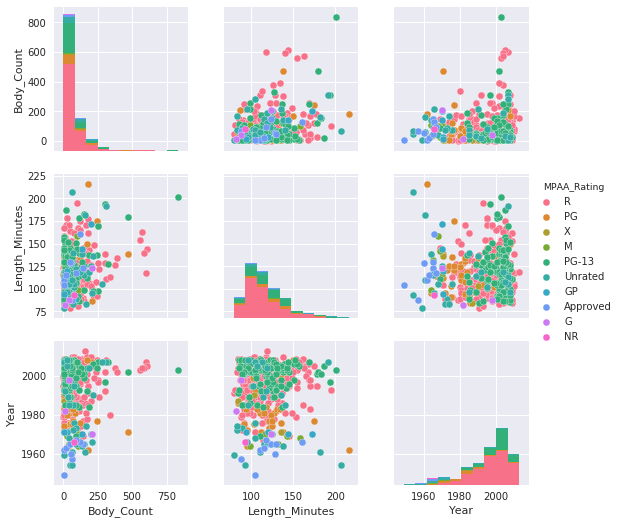

In [105]:
sns.pairplot(df, hue='MPAA_Rating', vars=quant_features)

In [106]:
# Homework 2, I
# Choost 3-6 features, explain
# Apply k-means at k=5, k=9
# In both cases take 10 or more random inits, choose the best over the K-means criterion
# Homework 2, II
# Take one partition
# Compare one of the features between two clusters using bootstrap
# Take a feature, find 95% confidence interval for grand mean using bootstrap
# Take a cluster, compare the grand mean with the within-cluster mean for the feature by using bootstrap
# Note: each application of bootstrap sohuld be done inboth pivotal and non-pivotal versions

In [107]:
quant_features = ['Body_Count', 'Length_Minutes', 'Year']

In [108]:
def normalize(vec):
    # center by mean, normalize by range
    return (vec - vec.mean())/(vec.max() - vec.min())

   Body_Count  Length_Minutes  Year  Approved  G  GP  M  NR  PG  PG-13  R  \
0           7             117  2002         0  0   0  0   0   0      0  1   
1          53             113  2002         0  0   0  0   0   0      0  1   
2         212             100  2007         0  0   0  0   0   0      0  1   
3          67             113  2007         0  0   0  0   0   0      0  1   
4         600             117  2007         0  0   0  0   0   0      0  1   

   Unrated  X  
0        0  0  
1        0  0  
2        0  0  
3        0  0  
4        0  0  


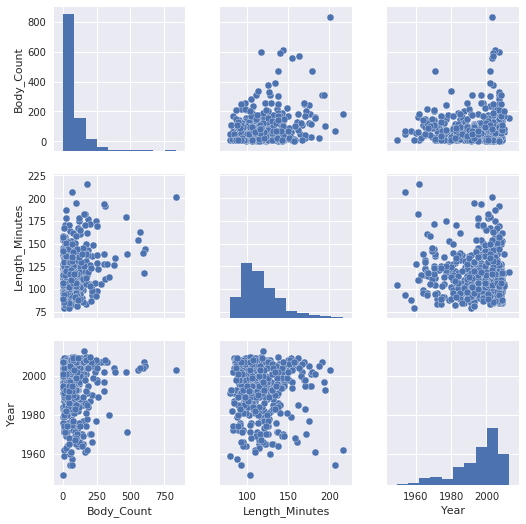

In [109]:
# K-means
features = quant_features+['MPAA_Rating']
task_df = pd.DataFrame(df[features])
#task_df['MPAA_Rating_dummy']
task_df = pd.concat([task_df, pd.get_dummies(task_df['MPAA_Rating'])], axis=1)
task_df = task_df.drop('MPAA_Rating', axis=1)
print(task_df.head())
sns.pairplot(task_df, vars=quant_features)

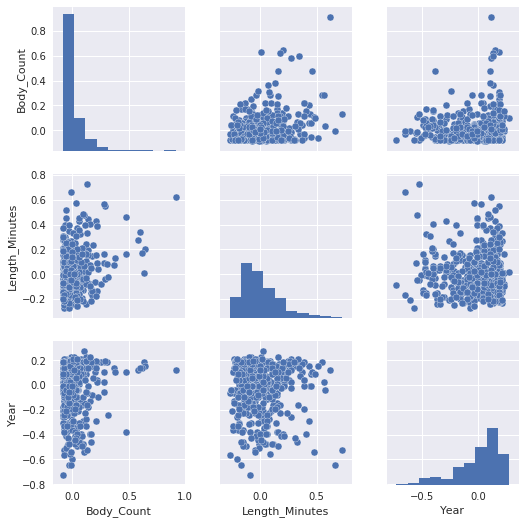

In [110]:
task_df = normalize(task_df)
sns.pairplot(task_df, vars=quant_features)

Sum of squared distances from points to cluster centers, k=5: 65.09974068146857


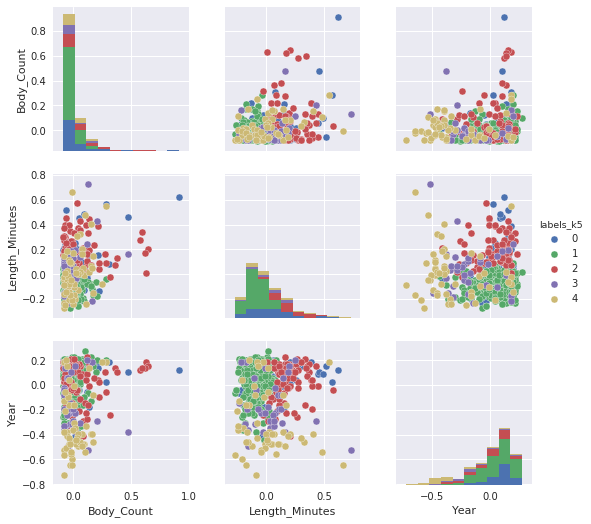

In [111]:
# Kmeans, k = 5
kmeans_k5 = KMeans(n_clusters=5, init='random', n_init=10, random_state=RANDOM_SEED) # kmeans, random initialization, 10 random inits, choose best by kmeans criterion
kmeans_k5.fit(task_df)
task_df['labels_k5'] = pd.Series(kmeans_k5.predict(task_df))
print('Sum of squared distances from points to cluster centers, k=5:', kmeans_k5.inertia_)
sns.pairplot(task_df, hue='labels_k5', vars=quant_features)

Sum of squared distances from points to cluster centers, k=9: 41.69861742938954


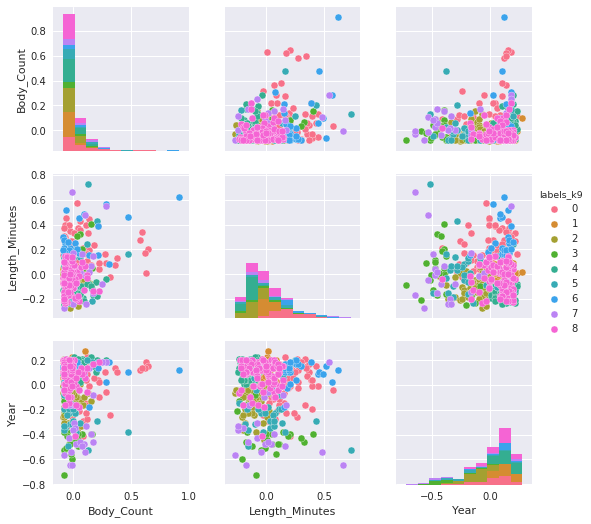

In [112]:
# Kmeans, k = 9
kmeans = KMeans(n_clusters=9, init='random', n_init=10, random_state=RANDOM_SEED) # kmeans, random initialization, 10 random inits, choose best by kmeans criterion
kmeans.fit(task_df)
task_df['labels_k9'] = pd.Series(kmeans.predict(task_df))
print('Sum of squared distances from points to cluster centers, k=9:', kmeans.inertia_)
sns.pairplot(task_df, hue='labels_k9', vars=quant_features)

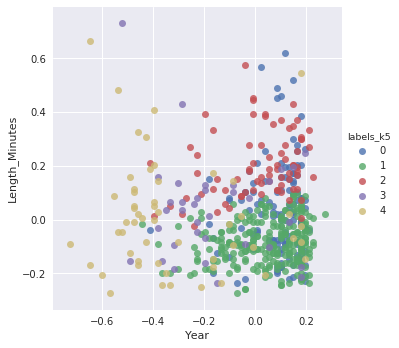

In [113]:
# Consider the patrition obtained for
sns.lmplot(x="Year", y="Length_Minutes", fit_reg=False, data=task_df, hue='labels_k5')

In [114]:
task_df.labels_k5.value_counts()

1    261
0    118
2     77
4     54
3     35
Name: labels_k5, dtype: int64

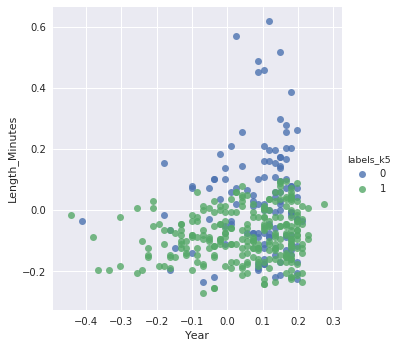

In [117]:
cluster_0 = df[task_df['labels_k5'] == 0]
cluster_1 = df[task_df['labels_k5'] == 1]
sns.lmplot(x="Year", y="Length_Minutes", fit_reg=False, data=task_df[(task_df['labels_k5'] == 0)|(task_df['labels_k5'] == 1)], hue='labels_k5')

In [122]:
target_feature = 'Body_Count'

count    118.000000
mean      70.906780
std      103.396836
min        3.000000
25%       11.250000
50%       45.500000
75%       88.500000
max      836.000000
Name: Body_Count, dtype: float64

count    261.000000
mean      50.559387
std       50.369799
min        1.000000
25%       15.000000
50%       34.000000
75%       73.000000
max      310.000000
Name: Body_Count, dtype: float64


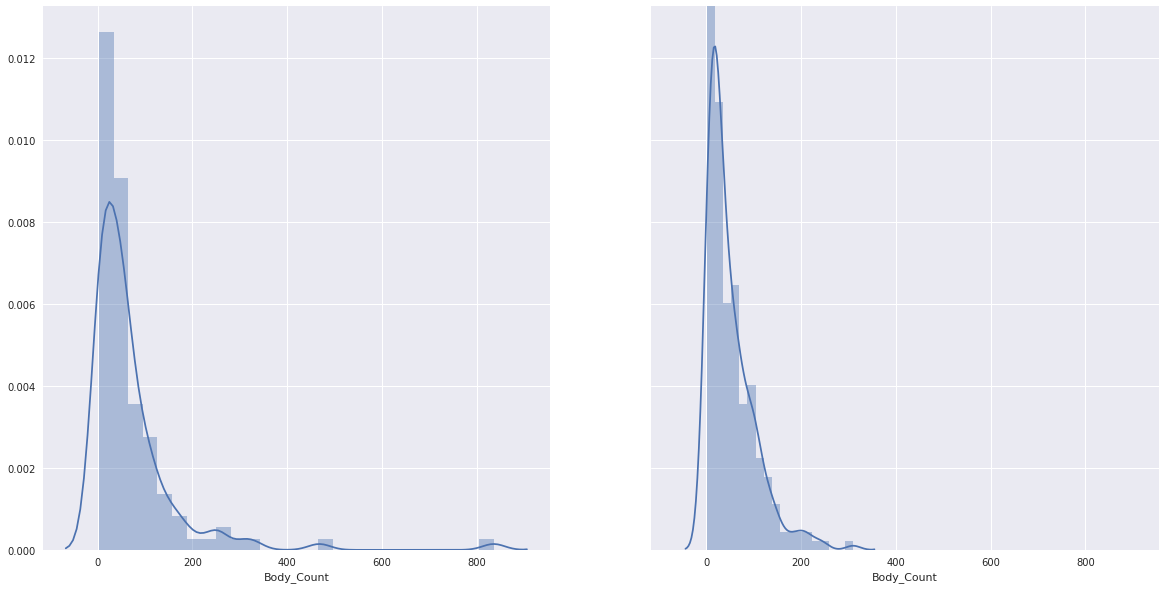

In [216]:
print(cluster_0[target_feature].describe())
print()
print(cluster_1[target_feature].describe())
# Top movie by body count, apparently
#cluster_0[cluster_0.Body_Count == cluster_0.Body_Count.max()]
fig = plt.figure(figsize=(20,10))
axes = fig.subplots(1, 2, sharex=True, sharey=True)

sns.distplot(cluster_0.Body_Count, ax=axes[0])
sns.distplot(cluster_1.Body_Count, ax=axes[1])

In [259]:
def bootstrap_sample(vec, size):
    return np.random.choice(vec, size=(vec.shape[0], size), replace=True)

def bootstrap_means(srs, sample_amount=5000):
    samples_ix = bootstrap_sample(srs.index, size=sample_amount).T
    means = [srs.loc[sample].mean() for sample in samples_ix]
    return means

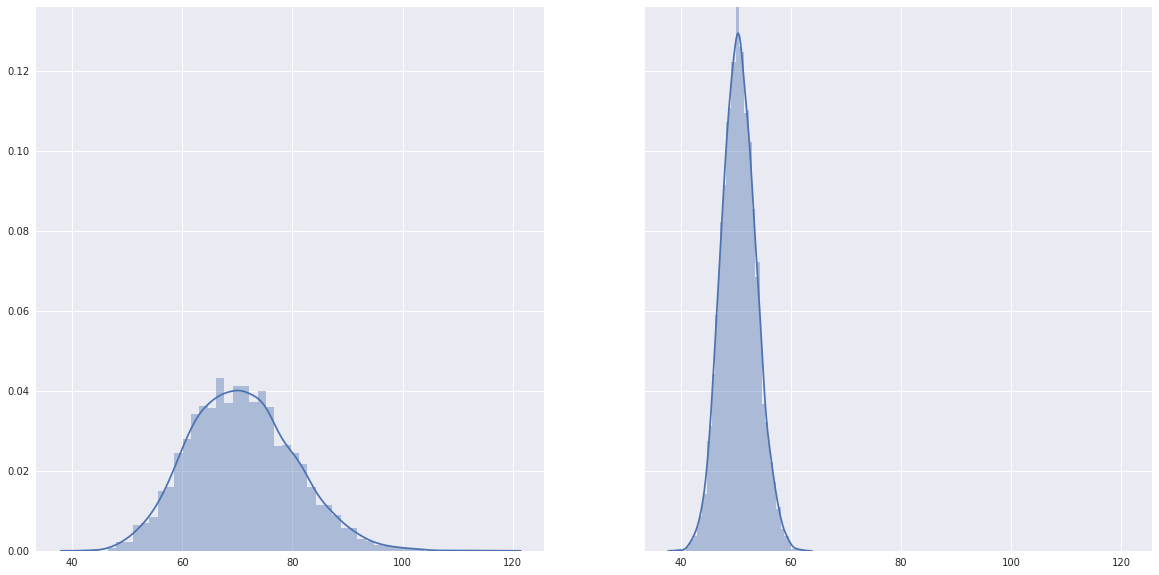

In [260]:
fig = plt.figure(figsize=(20,10))
axes = fig.subplots(1, 2, sharex=True, sharey=True)

sns.distplot(bootstrap_means(cluster_0.Body_Count), ax=axes[0])
sns.distplot(bootstrap_means(cluster_1.Body_Count), ax=axes[1])

## Homework 3

In [141]:
def categorize_number_of_deaths(num_of_deaths):
    if num_of_deaths < 10:
        return '9-'
    elif num_of_deaths < 100:
        return '10+'
    elif num_of_deaths < 200:
        return '100+'
    else:
        return '200+'

def categorize_rating(rating):
    if rating < 5.0:
        return '5.0-'
    elif rating < 7.0:
        return '5.0+'
    elif rating < 8.0:
        return '7.0+'
    else:
        return '8.0+'
    
def categorize_year(year):
    if year < 1990:
        return '1989-'
    elif year < 2000:
        return '1990+'
    elif year < 2005:
        return '2000+'
    else:
        return '2005+'

def make_quetelet(probabilites_df):
    res = probabilites_df.copy()
    res.drop(index='Total', columns='Total', inplace=True)
    for col in res:
        for row in res[col].index:
            res[col][row] = (probabilites_df[col][row] / probabilites_df['Total'][row] - probabilites_df[col]['Total']) / \
                             probabilites_df[col]['Total']
    return res

bodies = df['Body_Count'].apply(categorize_number_of_deaths)
imdb_rating = df['IMDB_Rating'].apply(categorize_rating)
year = df['Year'].apply(categorize_year)

contingency_table_imdb_bodies = pd.crosstab(bodies, imdb_rating, margins=True, margins_name='Total', normalize='all')
contingency_table_year_bodies = pd.crosstab(bodies, year, margins=True, margins_name='Total', normalize='all')


In [105]:
contingency_table_imdb_bodies * 100

IMDB_Rating,5.0+,5.0-,7.0+,8.0+,Total
Body_Count,,,,,
10+,31.743119,2.935780,18.165138,8.623853,61.467890
100+,5.504587,1.284404,5.871560,2.568807,15.229358
200+,1.834862,0.183486,4.220183,0.733945,6.972477
9-,7.522936,0.917431,5.137615,2.752294,16.330275
Total,46.605505,5.321101,33.394495,14.678899,100.000000


In [62]:
contingency_table_year_bodies * 100

Year,1989-,1990+,2000+,2005+,Total
Body_Count,,,,,
10+,13.944954,19.082569,11.192661,17.247706,61.467890
100+,6.605505,2.201835,3.119266,3.302752,15.229358
200+,1.284404,1.100917,1.834862,2.752294,6.972477
9-,3.302752,3.119266,5.321101,4.587156,16.330275
Total,25.137615,25.504587,21.467890,27.889908,100.000000


In [140]:
make_quetelet(contingency_table_imdb_bodies)

IMDB_Rating,5.0+,5.0-,7.0+,8.0+
Body_Count,,,,
10+,0.108062,-0.102419,-0.115057,-0.044216
100+,-0.224457,0.584961,0.154508,0.149096
200+,-0.435350,-0.505445,0.812464,-0.282895
9-,-0.011546,0.055792,-0.057908,0.148174


In [142]:
make_quetelet(contingency_table_year_bodies)

Year,1989-,1990+,2000+,2005+
Body_Count,,,,
10+,-0.097505,0.217223,-0.151805,0.006088
100+,0.725442,-0.433128,-0.045927,-0.222416
200+,-0.267192,-0.380916,0.225821,0.415339
9-,-0.195440,-0.251071,0.517814,0.007170
